## Grant cuts by state

Determine the Termination impact index for each US State.

In [3]:
# Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from bs4 import BeautifulSoup
import requests

df = pd.read_csv("/content/2024-04-07-NIH Grant Terminations_ Auto-Generated - grant_data.csv")

# Drop any rows where the 'cancellation_source' column is not 'HHS reported' or 'Self reported'
df_confirmed = df[df['cancellation_source'].isin(['HHS reported', 'Self reported', 'Self and HHS reported'])]
total_grants_count = len(df_confirmed)
print(f"There are {total_grants_count} rows in the dataframe.")

There are 770 rows in the dataframe.


## Download funding and number of awards by state 2020-204 from NIH RePORT

In [4]:
def get_table_from_nih_website(year):
  response = requests.get(f"https://report.nih.gov/award/index.cfm?ot=&fy={year}&state=&ic=&fm=&orgid=&distr=&rfa=&om=n&pid=#tab1")
  soup = BeautifulSoup(response.content, "html.parser")

  table = soup.find("table", {"id": "locationsortable"})

  # Extract headers
  headers = ["state","awards","funding"]

  # Extract rows
  rows = []
  for tr in table.find("tbody").find_all("tr"):
      row_data = [td.text.strip() for td in tr.find_all("td")]
      if row_data:  # Skip empty rows
          rows.append(row_data)
  # Create the pandas DataFrame
  df = pd.DataFrame(rows, columns=headers)
  df_no_award = df.drop('awards', axis=1)

  # In df_state_total, create a new column with to convert funding from '$1,000,000' strings to numbers
  df_no_award['funding'] = df_no_award['funding'].astype(str).str.replace(r'[$,]', '', regex=True)
  df_no_award['funding'] = pd.to_numeric(df_no_award['funding'], errors='coerce')

  return df_no_award

In [5]:
years = [2020, 2021, 2022, 2023, 2024]
dataframes_by_year = []

for year in years:
    df = get_table_from_nih_website(year)
    dataframes_by_year.append(df)

In [6]:
dataframes_by_year[0].head()

,state,funding
0,Alabama,383496345
1,Alaska,15887731
2,American Samoa,497841
3,Arizona,282446242
4,Arkansas,77281678


In [7]:
# Concatenate the DataFrames
merged_dfs_by_year = pd.concat(dataframes_by_year)

In [8]:
for year, index in zip(years, range(len(dataframes_by_year))):
    print(f"Year {year} has {len(dataframes_by_year[index])} rows.")
print(f"There are {len(merged_dfs_by_year)} rows in the merged dataframe.")

Year 2020 has 57 rows.
Year 2021 has 57 rows.
Year 2022 has 57 rows.
Year 2023 has 56 rows.
Year 2024 has 56 rows.
There are 283 rows in the merged dataframe.


In [9]:
# Interesting that that there are 57 rows in 2020-22 and 56 rows in 2023-24
states_2020 = dataframes_by_year[0]['state'].tolist()
states_2024 = dataframes_by_year[4]['state'].tolist()

for state in states_2020:
    if state not in states_2024:
        print(state)

American Samoa


Amerian Samoa is not listed in 2023 and 2024.

In [10]:
# Caluclate the total funding by state
total_funding_by_state = merged_dfs_by_year.groupby('state')['funding'].sum().reset_index()

In [11]:
total_funding_by_state['funding_five_year_average'] = (total_funding_by_state['funding'] / 5)

In [12]:
total_funding_by_state.head()

,state,funding,funding_five_year_average
0,Alabama,1922905700,384581140.0
1,Alaska,82230281,16446056.2
2,American Samoa,6930924,1386184.8
3,Arizona,1661493133,332298626.6
4,Arkansas,487029617,97405923.4


## Award remaining by State

In [13]:
# Group by 'org_state' and calculate the total 'award_remaining' by State.
state_award_remaining = df_confirmed.groupby('org_state')['award_remaining'].sum().sort_values(ascending=False).reset_index()

In [14]:
state_award_remaining.head()

,org_state,award_remaining
0,NY,5.826096e+08
1,NC,5.526199e+08
2,WA,4.095640e+08
3,CA,1.874997e+08
4,FL,8.014427e+07


In [15]:
# Check that States with low funding of ambiguous names are in 'total_funding_by_state'.

sense_check = ['DC', 'WY', 'SD', 'WV', 'MS', 'DE']
for state in sense_check:
    if state not in state_award_remaining['org_state'].values:
        print(f"{state} is not in 'state_award_remaining'")

WY is not in 'state_award_remaining'
SD is not in 'state_award_remaining'
WV is not in 'state_award_remaining'
DE is not in 'state_award_remaining'


In [16]:
# https://www.ssa.gov/international/coc-docs/states.html
# Used to match State codes with State names
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'District Of Columbia': 'DC',
    'Puerto Rico': 'PR',
    'Guam': 'GU',
    'American Samoa': 'AS',
    'U.S. Virgin Islands': 'VI',
    'Northern Mariana Islands': 'MP'
}

In [17]:
# Add the State Code
total_funding_by_state['state_code'] = total_funding_by_state['state'].map(state_mapping)

In [18]:
total_funding_by_state.head()

,state,funding,funding_five_year_average,state_code
0,Alabama,1922905700,384581140.0,AL
1,Alaska,82230281,16446056.2,AK
2,American Samoa,6930924,1386184.8,AS
3,Arizona,1661493133,332298626.6,AZ
4,Arkansas,487029617,97405923.4,AR


In [19]:
# Check that States with low funding of ambiguous names are in 'total_funding_by_state'.

sense_check_1 = ['District Of Columbia', 'Wyoming', 'South Dakota', 'West Virginia', 'Mississippi', 'Delaware']
for state in sense_check_1:
    if state not in total_funding_by_state['state'].values:
        print(f"{state} is not in 'total_funding_by_state'")

In [20]:
# Merge the two dataframes
states_merged_df = total_funding_by_state.merge(state_award_remaining, left_on='state_code', right_on='org_state')

In [21]:
states_merged_df.head()

,state,funding,funding_five_year_average,state_code,org_state,award_remaining
0,Alabama,1922905700,3.845811e+08,AL,AL,8.941150e+06
1,Alaska,82230281,1.644606e+07,AK,AK,1.018039e+06
2,Arizona,1661493133,3.322986e+08,AZ,AZ,5.311150e+06
3,Arkansas,487029617,9.740592e+07,AR,AR,1.056357e+06
4,California,26071870021,5.214374e+09,CA,CA,1.874997e+08


In [22]:
# Add a column for the the remaining award amount, as a percentage of the total funding for 2024
states_merged_df['award_remaining_percentage'] = states_merged_df['award_remaining'] / states_merged_df['funding_five_year_average'] * 100

In [23]:
states_merged_df.head()

,state,funding,funding_five_year_average,state_code,org_state,award_remaining,award_remaining_percentage
0,Alabama,1922905700,3.845811e+08,AL,AL,8.941150e+06,2.324906
1,Alaska,82230281,1.644606e+07,AK,AK,1.018039e+06,6.190172
2,Arizona,1661493133,3.322986e+08,AZ,AZ,5.311150e+06,1.598306
3,Arkansas,487029617,9.740592e+07,AR,AR,1.056357e+06,1.084489
4,California,26071870021,5.214374e+09,CA,CA,1.874997e+08,3.595824


In [24]:
# Check that States with low funding of ambiguous names are in 'total_funding_by_state'.

sense_check_2 = ['District Of Columbia', 'Wyoming', 'South Dakota', 'West Virginia', 'Mississippi', 'Delaware']
for state in sense_check_2:
    if state not in states_merged_df['state'].values:
        print(f"{state} is not in 'states_merged_df'")

Wyoming is not in 'states_merged_df'
South Dakota is not in 'states_merged_df'
West Virginia is not in 'states_merged_df'
Delaware is not in 'states_merged_df'


In [25]:
# Save to CSV
states_merged_df.to_csv('/content/percent_funding_by_state.csv', index=False)

## Chart

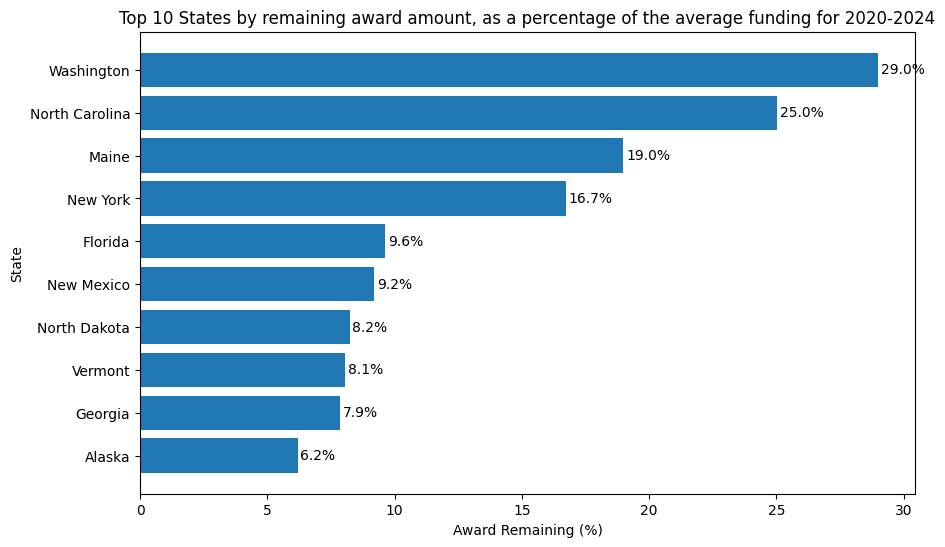

In [26]:
# Sort by award_remaining and get the top 10
top_10_states = states_merged_df.sort_values('award_remaining_percentage', ascending=False).head(10)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(top_10_states['state'], top_10_states['award_remaining_percentage'])
plt.xlabel('Award Remaining (%)')
plt.ylabel('State')
plt.title('Top 10 States by remaining award amount, as a percentage of the average funding for 2020-2024')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_width() + 0.1, p.get_y() + p.get_height() / 2.,
            '{:.1f}%'.format(p.get_width()),
            ha='left', va='center')

plt.show()

## Percent of funding for states which voted Democrat or Republican in the 2024 elections

In [28]:
# Election results 2024 referenced from Wikipedia
# https://en.wikipedia.org/wiki/2024_United_States_presidential_election#Results
df_state_info = pd.read_csv("/content/state-info.csv")

In [29]:
df_state_info.head()

,state,result
0,Alabama,republican
1,Alaska,republican
2,Arizona,republican
3,Arkansas,republican
4,California,democrat


In [30]:
states_merged_df.head()

,state,funding,funding_five_year_average,state_code,org_state,award_remaining,award_remaining_percentage
0,Alabama,1922905700,3.845811e+08,AL,AL,8.941150e+06,2.324906
1,Alaska,82230281,1.644606e+07,AK,AK,1.018039e+06,6.190172
2,Arizona,1661493133,3.322986e+08,AZ,AZ,5.311150e+06,1.598306
3,Arkansas,487029617,9.740592e+07,AR,AR,1.056357e+06,1.084489
4,California,26071870021,5.214374e+09,CA,CA,1.874997e+08,3.595824


In [31]:
# Merge the 'states_merged_df' and 'df_state_info' dataframes on the column 'state'
merged_state_info = pd.merge(states_merged_df, df_state_info, left_on='state', right_on='state', how='left')

In [32]:
merged_state_info.head()

,state,funding,funding_five_year_average,state_code,org_state,award_remaining,award_remaining_percentage,result
0,Alabama,1922905700,3.845811e+08,AL,AL,8.941150e+06,2.324906,republican
1,Alaska,82230281,1.644606e+07,AK,AK,1.018039e+06,6.190172,republican
2,Arizona,1661493133,3.322986e+08,AZ,AZ,5.311150e+06,1.598306,republican
3,Arkansas,487029617,9.740592e+07,AR,AR,1.056357e+06,1.084489,republican
4,California,26071870021,5.214374e+09,CA,CA,1.874997e+08,3.595824,democrat


In [33]:
merged_state_info.to_csv('/content/merged_state_info.csv', index=False)

In [34]:
republican_df = merged_state_info[merged_state_info['result'] == 'republican']
democrat_df = merged_state_info[merged_state_info['result'] == 'democrat']

In [35]:
republican_df.head()

,state,funding,funding_five_year_average,state_code,org_state,award_remaining,award_remaining_percentage,result
0,Alabama,1922905700,384581140.0,AL,AL,8941150.23,2.324906,republican
1,Alaska,82230281,16446056.2,AK,AK,1018039.15,6.190172,republican
2,Arizona,1661493133,332298626.6,AZ,AZ,5311150.05,1.598306,republican
3,Arkansas,487029617,97405923.4,AR,AR,1056356.83,1.084489,republican
8,Florida,4156522680,831304536.0,FL,FL,80144271.75,9.640784,republican


In [36]:
total_republican_funding = republican_df['funding_five_year_average'].sum()
total_democrat_funding = democrat_df['funding_five_year_average'].sum()

In [37]:
total_republican_award_remaining = republican_df['award_remaining'].sum()
total_democrat_award_remaining = democrat_df['award_remaining'].sum()

In [38]:
republican_award_remaining_percentage = total_republican_award_remaining / (total_republican_funding / 5) * 100
democrat_award_remaining_percentage = total_democrat_award_remaining / (total_democrat_funding / 5) * 100

In [39]:
print(f"Total republican funding 5 years: ${total_republican_funding:,.0f}")
print(f"Total republican award remaining: ${total_republican_award_remaining:,.0f}")
print(f"Total republican award remaining percentage: {republican_award_remaining_percentage:.2f}%")

Total republican funding 5 years: $14,620,810,749
Total republican award remaining: $887,099,950
Total republican award remaining percentage: 30.34%


In [40]:
print(f"Total democrat funding 5 years: ${total_democrat_funding:,.0f}")
print(f"Total democrat award remaining: ${total_democrat_award_remaining:,.0f}")
print(f"Total democrat award remaining percentage: {democrat_award_remaining_percentage:.2f}%")

Total democrat funding 5 years: $21,320,061,307
Total democrat award remaining: $1,472,676,939
Total democrat award remaining percentage: 34.54%
